# Combustion and Air Pollution HW #6

#### Consider combustion of propane ($C_3H_{8}$). Propane and air are introduced to a constant volume chamber. First let's consider $\phi$ = 1.0 and atmospheric pressure. Upon ignition, combustion of the premixed fuel/air occurs at constant volume and constant internal energy (assuming that the chamber is adiabatic).

#### Calculate:
1. The adiabatic flame temperature if the fuel and air are preheated and introduced into the chamber at 750 K, for $\phi$ = 0.5, 0.8, 1.0, and 1.3. Plot the result ( $T_{flame}$ vs $\phi$ ) with Excel, or use Python if you are comfortable.
2. The NO mole fraction at equlibrium for $\phi$ = 0.5, 0.8, 1.0, and 1.3. Plot the result ( $x_{NO}$ vs $\phi$ ) with Excel, or use Python if you are comfortable.
3. The time at which the fuel ignites for $\phi$ =  0.8, 1.0, and 1.3
4. The time at which mole fraction of the fuel drops below 100 ppm for each $\phi$
5. At what time should we quench the reaction (by rapid expansion) if we want to keep NO emissions below 1000 ppm, for each $\phi$? Is this before or after the time in part (4)?
6. Also calculate 1-5 for the $\phi$ = 1.0 case by hand / using STANJAN.

In this homework we will use more detailed combustion chemistry then we previously considered in this class, along with the Zeldovich mechanism for thermal fixation of atmospheric N2, to model and predict NOx formation in heptane combustion.
We use an open source software tool called [Cantera](http://www.cantera.org/docs/sphinx/html/index.html) which helps us solve thermodynamics and kinetics problems.

This homework was adapted from a lecture in Prof. Richard West's undergraduate chemical kinetics class in the Department of Chemical Engineering as well as existing Python notebooks in the [cantera-jupyter project](https://github.com/cantera/cantera-jupyter). 

The below code will guide you through questions 1-5.

### Simply click inside the cells below to be able to type in and edit them, and press Shift+Enter to execute the code in a cell that is selected.

In [1]:
# Imports
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

We will consider an n-heptane mechanism we from the Lawrence Livermore National Lab (LLNL), with the 3-reaction Zeldovich mechanism manually added to it. This mechanism includes reactions important in the combustion of propane. First we create a Solution object in Cantera for n-heptane gas that includes all of the thermodynamic and kinetic parameters needed to describe its combustion. (Don't worry about the warning)

In [2]:
gas = ct.Solution('heptanesymp159.cti')



**** WARNING ****
For species c7h15o-1, discontinuity in cp/R detected at Tmid = 1391
	Value computed using low-temperature polynomial:  53.0168.
	Value computed using high-temperature polynomial: 52.748.


We can print out some chemical species and reactions that are considered in the mechanism:

In [19]:
print "Some of the species in the mechanism:"
print " ".join(gas.species_names[:20])
print "\n"

print "Model includes reactions that break down the fuel ('c3h8'):"
for i in range(320,340):
    print gas.reaction(i)
print "\n"

print "And also contains small molecule chemistry:"
for i in range(20):
    print gas.reaction(i)
print "\n"
print "There are {0} total reactions in this mechanism!".format(len(gas.reactions()))

Some of the species in the mechanism:
n2 ch3 h ch4 h2 oh h2o o c2h6 c2h5 hco co co2 o2 h2o2 ho2 c2h4 ch3oh ch2oh ch3o


Model includes reactions that break down the fuel ('c3h8'):
c3h8 => c2h5 + ch3
c2h5 + ch3 => c3h8
c3h8 + o2 => ho2 + ic3h7
ho2 + ic3h7 => c3h8 + o2
c3h8 + o2 => ho2 + nc3h7
ho2 + nc3h7 => c3h8 + o2
c3h8 + h => h2 + ic3h7
h2 + ic3h7 => c3h8 + h
c3h8 + h => h2 + nc3h7
h2 + nc3h7 => c3h8 + h
c3h8 + o => ic3h7 + oh
ic3h7 + oh => c3h8 + o
c3h8 + o => nc3h7 + oh
nc3h7 + oh => c3h8 + o
c3h8 + oh => h2o + nc3h7
h2o + nc3h7 => c3h8 + oh
c3h8 + oh => h2o + ic3h7
h2o + ic3h7 => c3h8 + oh
c3h8 + ho2 => h2o2 + ic3h7
h2o2 + ic3h7 => c3h8 + ho2


And also contains small molecule chemistry:
ch3 + h (+M) => ch4 (+M)
ch4 (+M) => ch3 + h (+M)
ch4 + h => ch3 + h2
ch3 + h2 => ch4 + h
ch4 + oh => ch3 + h2o
ch3 + h2o => ch4 + oh
ch4 + o => ch3 + oh
ch3 + oh => ch4 + o
c2h6 + ch3 => c2h5 + ch4
c2h5 + ch4 => c2h6 + ch3
hco + oh => co + h2o
co + h2o => hco + oh
co + oh => co2 + h
co2 + h => co

Let's look at the last few reactions in the mechanism, representing the Zeldovich mechanism.

In [4]:
zeldovich = gas.reactions()[-3:]
for rxn in zeldovich:
    print rxn.equation, rxn.rate

n + no <=> n2 + o Arrhenius(A=2.7e+10, b=0, E=1.48532e+06)
n + o2 <=> no + o Arrhenius(A=9e+06, b=1, E=2.7196e+07)
n + oh <=> h + no Arrhenius(A=3.36e+10, b=0, E=1.61084e+06)


#### 1. Calculate the adiabatic flame temperature if the fuel and air are preheated and introduced into the chamber at 500 K. 
First, we need to initialize the fuel at the correct temperature (K), pressure (Pa) and mole fractions (these can be molar ratios, Cantera will normalize them, like in STANJAN).
Replace the "xxxx" with the correct number of moles.

We'll find the equilibrium flame temperature by equilibrating keeping volume and internal energy
constant.

For eq ratio 0.5, adiabatic flame temperature is 2147
For eq ratio 0.8, adiabatic flame temperature is 2603
For eq ratio 1.0, adiabatic flame temperature is 2740
For eq ratio 1.3, adiabatic flame temperature is 2753


(0.4, 1.4)

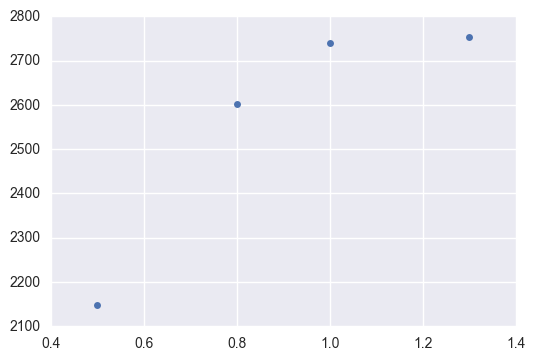

In [57]:
equivalence_ratios = np.array([0.5,0.8,1.0,1.3])
T = np.zeros_like(equivalence_ratios)

# phi=0.5
gas.TPX = 750, 1e5, 'c3h8:1.0,o2:10.0,n2:37.8'
gas.equilibrate('UV')
T[0] = gas.T

# phi=0.8
gas.TPX = 750, 1e5, 'c3h8:1.0,o2:6.25,n2:23.63'
gas.equilibrate('UV')
T[1] = gas.T

#phi=1.0
gas.TPX = 750, 1e5, 'c3h8:1.0,o2:5.0,n2:18.8'
gas.equilibrate('UV')
T[2] = gas.T

#phi=1.3
gas.TPX = 750, 1e5, 'c3h8:1.0,o2:3.85,n2:14.54'
gas.equilibrate('UV')
T[3] = gas.T
            
for phi, temp in zip(equivalence_ratios, T):
    print "For eq ratio {0}, adiabatic flame temperature is {1}".format(round(phi,1), int(round(temp,0)))

#gas.TPX = 1000, 1e5, 'nc7h16:1.0,o2:xxxx,n2:xxxx'

plt.plot(equivalence_ratios, T, linestyle='', marker='.', ms=10)
plt.xlim(0.4,1.4)

#### 2. Calculate the NO mole fraction at equlibrium for $\phi$ = 0.5, 0.8, 1.0, and 1.3
This time, we'll use a loop to go through equivalence ratios between 0.1 - 2.0 

For eq ratio 0.5, NO = 7344 ppm
For eq ratio 0.8, NO = 11175 ppm
For eq ratio 1.0, NO = 9132 ppm
For eq ratio 1.3, NO = 3027 ppm


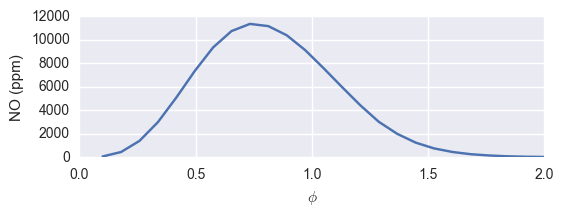

In [58]:
equivalence_ratios = np.linspace(0.1, 2, 25)
x_NO = np.zeros_like(equivalence_ratios)
temperatures = np.zeros_like(equivalence_ratios)
for i, phi in enumerate(equivalence_ratios):
    mol_O2 = 5.0 / phi
    mol_N2 = 3.78 * mol_O2
    X_string = "c3h8:1.0,o2:" + str(round(mol_O2, 2)) + ",n2:" + str(round(mol_N2, 2))
    gas.TPX = 750, 1e5, X_string
    gas.equilibrate('UV')
    temperatures[i] = gas.T
    x_NO[i] = gas['no'].X[0]
    if round(phi,1) in [0.5, 0.8, 1.0, 1.3]:
        print "For eq ratio {0}, NO = {1} ppm".format(round(phi,1), int(1E6*x_NO[i]))
        
plt1= plt.subplot(2,1,1)
#plt2= plt.subplot(2,1,2)
plt1.plot(equivalence_ratios, x_NO*1E6)
#plt2.plot(equivalence_ratios, temperatures)
plt1.set_xlabel('$\phi$')
plt1.set_ylabel('NO (ppm)')

#### 3. Calculate the time at which the fuel ignites for $\phi$ = 0.5, 0.8, 1.0, and 1.3
#### 4. Calculate the time at which mole fraction of the fuel drops below 100 ppm for each $\phi$
#### 5. At what time should we quench the reaction if we want to keep NO emissions below 1000 ppm? Is this before or after the time in part (4)?

For these three questions, we need to calculate kinetics.
The following code will utilize an ideal gas reactor (constant volume) in Cantera to model the reactor. We will print the answers to questions 3-5.

At equivalence ratio 0.8, fuel ignites at 25.3134 seconds
At equivalence ratio 0.8, fuel reaches 100 ppm at 25.315 seconds
At equivalence ratio 0.8, reaction should be quenched at 25.3154 seconds


At equivalence ratio 1.0, fuel ignites at 22.1324 seconds
At equivalence ratio 1.0, fuel reaches 100 ppm at 22.1338 seconds
At equivalence ratio 1.0, reaction should be quenched at 22.134 seconds


At equivalence ratio 1.3, fuel ignites at 18.9212 seconds
At equivalence ratio 1.3, fuel reaches 100 ppm at 18.9224 seconds
At equivalence ratio 1.3, reaction should be quenched at 18.9228 seconds




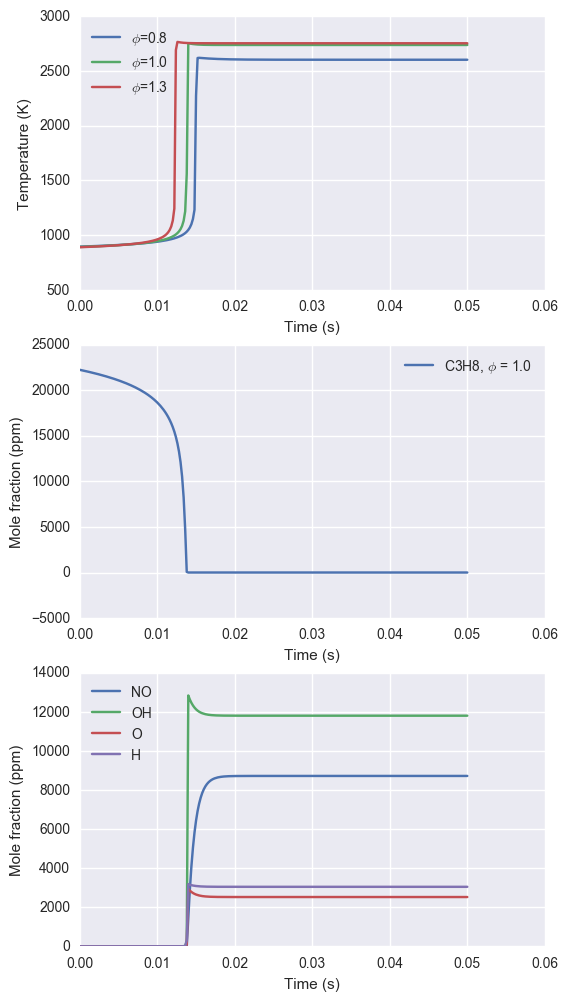

In [56]:
equivalence_ratios = np.array([0.8, 1.0, 1.3])
ignitions = np.array([25.30, 22.12, 18.91])
i_fuel = gas.species_names.index('c3h8')
i_no = gas.species_names.index('no')
i_oh = gas.species_names.index('oh')
i_o = gas.species_names.index('o')
i_h = gas.species_names.index('h')
i_n2 = gas.species_names.index('n2')

plt.figure(figsize=(6,12))
plt_temps = plt.subplot(3,1,1)
plt_input_spec = plt.subplot(3,1,2)
plt_radicals = plt.subplot(3,1,3)

for phi, t in zip(equivalence_ratios, ignitions):
    
    mol_O2 = 5.0 / phi
    mol_N2 = 3.78 * mol_O2
    X_string = "c3h8:1.0,o2:" + str(round(mol_O2, 2)) + ",n2:" + str(round(mol_N2, 2))
    gas.TPX = 750, 1e5, X_string

    reactor = ct.IdealGasReactor(gas)
    reactor_network = ct.ReactorNet([reactor])

    start_time = t  #starting time
    end_time = t+0.05 # seconds
    n_steps = 251
    times = np.linspace(start_time, end_time, n_steps)
    concentrations = np.zeros((n_steps, gas.n_species))
    mole_frac = np.zeros((n_steps, gas.n_species))
    pressures = np.zeros(n_steps)
    temperatures = np.zeros(n_steps)

    reached_100ppm = False
    ignited = False
    reached_NO = False

    for n, time in enumerate(times):
        if time > 0:
            reactor_network.advance(time)
        temperatures[n] = reactor.T
        pressures[n] = reactor.thermo.P
        concentrations[n,:] = reactor.thermo.concentrations
        mole_frac[n,:] = gas.X
        if reactor.T > 1000 and not ignited: # Ignition time, estimate it to be when T is above 1000 K
            ignited = True
            print "At equivalence ratio {0}, fuel ignites at {1} seconds".format(str(phi), str(round(time,6)))
        if 1e6*mole_frac[n, i_fuel] < 100.0 and not reached_100ppm: # Fuel is < 100 ppm
            reached_100ppm = True
            print "At equivalence ratio {0}, fuel reaches 100 ppm at {1} seconds".format(str(phi), str(round(time,6)))
        if 1e6*mole_frac[n, i_no] >= 1000.0 and not reached_NO: # NO is >= 1000 ppm
            reached_NO = True
            print "At equivalence ratio {0}, reaction should be quenched at {1} seconds".format(str(phi), str(round(time,6)))
            print "\n"
    
    plt_temps.plot(times-t, temperatures, label = "$\phi$=" + str(phi)) # Renormalized to just before ignition
    
    # Print other plots just for stoichiometric combustion
    if phi == 1.0:
        plt_input_spec.plot(times-t, 1E6*mole_frac[:, i_fuel], label = "C3H8, $\phi$ = 1.0")
        plt_radicals.plot(times-t, 1E6*mole_frac[:,i_no], label = "NO")
        plt_radicals.plot(times-t, 1E6*mole_frac[:,i_oh], label = "OH")
        plt_radicals.plot(times-t, 1E6*mole_frac[:,i_o], label = "O")
        plt_radicals.plot(times-t, 1E6*mole_frac[:,i_h], label = "H")
plt_temps.set_xlabel("Time (s)")
plt_temps.set_ylabel("Temperature (K)")
plt_temps.legend(loc='best')
plt_input_spec.set_xlabel("Time (s)")
plt_input_spec.set_ylabel("Mole fraction (ppm)")
plt_input_spec.legend(loc='best')
plt_radicals.set_xlabel("Time (s)")
plt_radicals.set_ylabel("Mole fraction (ppm)")
plt_radicals.legend(loc='best')

Just want to check at least one rate to make sure it's reasonably close to the one in the book...These came from the gri mech.

In [ ]:
T = np.linspace(300,2500,100)

In [ ]:
A = rxn.rate.pre_exponential_factor / 1000.0
n = rxn.rate.temperature_exponent
Ea = rxn.rate.activation_energy / 1000.0

In [ ]:
rate_mech = A * T**n * np.exp(-Ea/8.314/T)
rate_book = 7.1E7 * np.exp(-450.0/T)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.plot(1.0/T, np.log(rate_mech))
plt.plot(1.0/T, np.log(rate_book))